# Chapter 8: Problems with the Error

Load the packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Generalized Least Squares

Load the data:

In [2]:
globwarm = pd.read_csv("data/globwarm.csv")
globwarm.head()

,nhtemp,wusa,jasper,westgreen,chesapeake,tornetrask,urals,mongolia,tasman,year
0,NaN,-0.66,-0.03,0.03,-0.66,0.33,-1.49,0.83,-0.12,1000
1,NaN,-0.63,-0.07,0.09,-0.67,0.21,-1.44,0.96,-0.17,1001
2,NaN,-0.60,-0.11,0.18,-0.67,0.13,-1.39,0.99,-0.22,1002
3,NaN,-0.55,-0.14,0.30,-0.68,0.08,-1.34,0.95,-0.26,1003
4,NaN,-0.51,-0.15,0.41,-0.68,0.06,-1.30,0.87,-0.31,1004


Fit the model:

In [3]:
lmod = smf.ols(formula='nhtemp ~ wusa + jasper + westgreen + chesapeake + tornetrask + urals + mongolia + tasman',
               data=globwarm).fit()
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 nhtemp   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     15.47
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           5.03e-16
Time:                        15:55:20   Log-Likelihood:                 50.995
No. Observations:                 145   AIC:                            -83.99
Df Residuals:                     136   BIC:                            -57.20
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2426      0.027     -8.980      0.000      -0.296      -0.189
wusa           0.0774      0.043      1.803      0.074      -0.008       0.162
jasper        -0.2288      0.078     -2.929      0.004      -0.383      -0.074
westgreen      0.0096      0.042      0.229      0.819      -0.073       0.092
chesapeake    -0.0321      0.034     -0.943      0.347      -0.099       0.035
tornetrask     0.0927      0.045      2.057      0.042       0.004       0.182
urals          0.1854      0.091      2.027      0.045       0.005       0.366
mongolia       0.0420      0.046      0.917      0.361      -0.049       0.133
tasman         0.1155      0.030      3.834      0.000       0.056       0.175
==============================================================================
Omnibus:                       12.501   Durbin-Watson:                   0.817
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.388
Skew:                           0.490   Prob(JB):                     0.000168
Kurtosis:                       4.384   Cond. No.                         12.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot successive residuals:

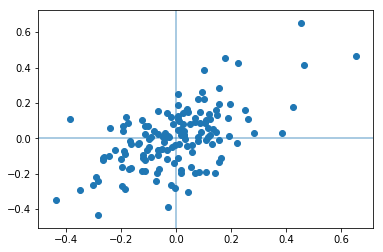

In [4]:
plt.scatter(lmod.resid.iloc[:-1],lmod.resid.iloc[1:])
plt.axhline(0,alpha=0.5)
plt.axvline(0,alpha=0.5)
plt.show()

Compute the correlation:

In [5]:
np.corrcoef(lmod.resid.iloc[:-1],lmod.resid.iloc[1:])

array([[1.        , 0.58333899],
       [0.58333899, 1.        ]])

Fit the uncorrelated model and then iterate the fit. Produces result very similar to the correlation of the residuals. Different from the R correlation of 0.71

In [6]:
globwarm = globwarm.dropna()
X = sm.add_constant(globwarm.iloc[:,1:9])
gmod = sm.GLSAR(globwarm.nhtemp, X, rho=1)
res=gmod.iterative_fit(maxiter=6)
gmod.rho

array([0.58221337])

Alternative method that shows the iterative nature of the solution:

In [7]:
gmod = sm.GLSAR(globwarm.nhtemp, X, rho=1)
for i in range(6):
     results = gmod.fit()
     print("AR coefficients: {0}".format(gmod.rho))
     rho, sigma = sm.regression.yule_walker(results.resid,order=gmod.order)
     gmod = sm.GLSAR(globwarm.nhtemp, X, rho)


AR coefficients: [0.]
AR coefficients: [0.57494252]
AR coefficients: [0.58194786]
AR coefficients: [0.58220381]
AR coefficients: [0.58221337]
AR coefficients: [0.58221373]


Read in the data for the blocked example. Need to make variety categorical. For reasons unclear to me, the mixed effect modeling function throws an error if the response is called *yield*. We create the same variable but with a different name: *grams*.

In [8]:
oatvar = pd.read_csv("data/oatvar.csv", index_col=0)
oatvar['variety'] = oatvar['variety'].astype('category')
oatvar['grams'] = oatvar['yield']
oatvar.head()

,yield,block,variety,grams
1,296,I,1,296
2,357,II,1,357
3,340,III,1,340
4,331,IV,1,331
5,348,V,1,348


Can do mixed effect model but would need to calculate correlation from this.

In [9]:
mmod = smf.mixedlm("grams ~ variety",oatvar,groups=oatvar['block']).fit()
mmod.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM  Dependent Variable:  grams    
No. Observations:  40       Method:              REML     
No. Groups:        5        Scale:               1336.9044
Min. group size:   8        Likelihood:          -170.6771
Max. group size:   8        Converged:           Yes      
Mean group size:   8.0                                    
----------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    334.400   21.040 15.894 0.000 293.162 375.638
variety[T.2]  42.200   23.125  1.825 0.068  -3.124  87.524
variety[T.3]  28.200   23.125  1.219 0.223 -17.124  73.524
variety[T.4] -47.600   23.125 -2.058 0.040 -92.924  -2.276
variety[T.5] 105.000   23.125  4.541 0.000  59.676 150.324
variety[T.6]  -3.800   23.125 -0.164 0.869 -49.124  41.524
variety[T.7] -16.000   23.125 -0.692 0.489 -61.324  29.324
variety[T.8]  49.800   23.125  2.154 0.031   4.476  95.124
Group Var    876.492   21.576                             
==========================================================

"""

GEE model is also possible

In [10]:
ind = sm.cov_struct.Exchangeable()
gmod = smf.gee("grams ~ variety", "block", oatvar, cov_struct = ind ).fit()
gmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                       grams   No. Observations:                   40
Model:                                 GEE   No. clusters:                        5
Method:                        Generalized   Min. cluster size:                   8
                      Estimating Equations   Max. cluster size:                   8
Family:                           Gaussian   Mean cluster size:                 8.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Tue, 25 Sep 2018   Scale:                        2213.400
Covariance type:                    robust   Time:                         15:55:20
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      334.4000      9.409     35.541      0.000     315.959     352.841
variety[T.2]    42.2000     22.420      1.882      0.060      -1.743      86.143
variety[T.3]    28.2000     32.653      0.864      0.388     -35.798      92.198
variety[T.4]   -47.6000     17.136     -2.778      0.005     -81.186     -14.014
variety[T.5]   105.0000     23.634      4.443      0.000      58.678     151.322
variety[T.6]    -3.8000     14.750     -0.258      0.797     -32.709      25.109
variety[T.7]   -16.0000     26.032     -0.615      0.539     -67.022      35.022
variety[T.8]    49.8000     34.238      1.455      0.146     -17.306     116.906
==============================================================================
Skew:                          0.0045   Kurtosis:                      -0.2204
Centered skew:                 0.4576   Centered kurtosis:              0.0147
==============================================================================
"""

In [11]:
ind.summary()

'The correlation between two observations in the same cluster is 0.336'

## Weighted Least Squares

Read in the French Presidential Election data:

In [12]:
fpe = pd.read_csv("data/fpe.csv",index_col=0)
fpe.head()

,EI,A,B,C,D,E,F,G,H,J,K,A2,B2,N
Ain,260,51,64,36,23,9,5,4,4,3,3,105,114,17
Alpes,75,14,17,9,9,3,1,2,1,1,1,32,31,5
Ariege,107,27,18,13,17,2,2,2,1,1,1,57,33,6
Bouches.du.Rhone,1036,191,204,119,205,29,13,13,10,10,6,466,364,30
Charente.Maritime,367,71,76,47,37,8,34,5,4,4,2,163,142,17


Fit the model with weights:

In [13]:
wmod = smf.wls("A2 ~ A + B + C + D + E + F + G + H + J + K +N -1", data=fpe, weights = 1/fpe.EI ).fit()
wmod.params

A    1.067130
B   -0.105051
C    0.245958
D    0.926188
E    0.249397
F    0.755110
G    1.972212
H   -0.566217
J    0.611642
K    1.210658
N    0.529353
dtype: float64

Fit the model without weights:

In [14]:
lmod = smf.wls("A2 ~ A + B + C + D + E + F + G + H + J + K +N -1", data=fpe).fit()
lmod.params

A    1.075148
B   -0.124559
C    0.257447
D    0.904537
E    0.670677
F    0.782533
G    2.165655
H   -0.854288
J    0.144419
K    0.518133
N    0.558272
dtype: float64

Multiplying the weights by a constant makes no difference:

In [15]:
wmod = smf.wls("A2 ~ A + B + C + D + E + F + G + H + J + K +N -1", data=fpe, weights = 53/fpe.EI ).fit()
wmod.params

A    1.067130
B   -0.105051
C    0.245958
D    0.926188
E    0.249397
F    0.755110
G    1.972212
H   -0.566217
J    0.611642
K    1.210658
N    0.529353
dtype: float64

Fit a reduced model. Doesn't seem to be an offset option so need to modify the response:

In [16]:
y = fpe.A2 - fpe.A - fpe.G - fpe.K
X = fpe.loc[:,["C","D","E","F","N"]]
wmod = sm.WLS(y, X, weights = 53/fpe.EI ).fit()
wmod.params

C    0.225773
D    0.969977
E    0.390204
F    0.744240
N    0.608539
dtype: float64

Contrained least squares - need some trickery to get the weights right.

In [17]:
y = fpe.A2
X = fpe.loc[:,["A","B","C","D","E","F","G","H","J","K","N"]]
weights = 1/fpe.EI
Xw = (X.T * np.sqrt(weights)).T
yw = y * np.sqrt(weights)

In [18]:
res = sp.optimize.lsq_linear(Xw, yw, bounds=(0, 1))
pd.Series(np.round(res.x,3),index=lmod.params.index)

A    1.000
B    0.000
C    0.208
D    0.969
E    0.359
F    0.743
G    1.000
H    0.367
J    0.000
K    1.000
N    0.575
dtype: float64

IRWLS example

In [19]:
cars = pd.read_csv("data/cars.csv")
cars.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


Show that heteroscedascity is present

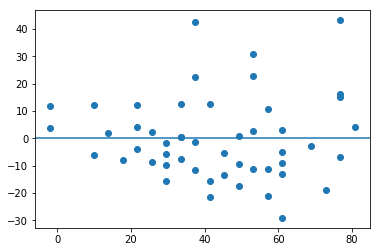

In [20]:
lmod = smf.ols(formula='dist ~ speed', data=cars).fit()
plt.scatter(lmod.fittedvalues,lmod.resid)
plt.axhline(0)
plt.show()

In [21]:
lmod.params

Intercept   -17.579095
speed         3.932409
dtype: float64

Iterate once using absolute residuals as response for linear relationship in the SD

In [22]:
gamma = np.mean(np.abs(lmod.resid) - cars.speed)
lmod = smf.wls(formula='dist ~ speed', data=cars, weights=np.sqrt(1/(gamma+cars.speed))).fit()
gamma, lmod.params

(-3.8198808759124097, Intercept   -11.180437
 speed         3.541541
 dtype: float64)

Plot the weights

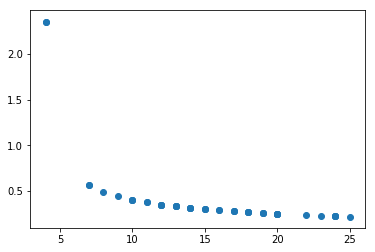

In [23]:
weights=np.sqrt(1/(gamma+cars.speed))
plt.scatter(cars.speed, weights)
plt.show()

## Testing for Lack of fit 

Read in the data:

In [24]:
corrosion = pd.read_csv("data/corrosion.csv")
corrosion.head()

,Fe,loss
0,0.01,127.6
1,0.48,124.0
2,0.71,110.8
3,0.95,103.9
4,1.19,101.5


Fit the model:

In [25]:
lmod = smf.ols(formula='loss ~ Fe', data=corrosion).fit()
lmod.summary()

/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   loss   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     352.3
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           1.06e-09
Time:                        15:55:20   Log-Likelihood:                -31.890
No. Observations:                  13   AIC:                             67.78
Df Residuals:                      11   BIC:                             68.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    129.7866      1.403     92.524      0.000     126.699     132.874
Fe           -24.0199      1.280    -18.769      0.000     -26.837     -21.203
==============================================================================
Omnibus:                        1.170   Durbin-Watson:                   2.535
Prob(Omnibus):                  0.557   Jarque-Bera (JB):                0.958
Skew:                           0.551   Prob(JB):                        0.619
Kurtosis:                       2.255   Cond. No.                         2.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Set up the plot:

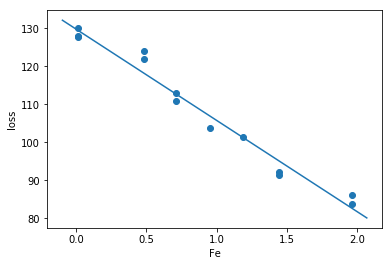

In [26]:
fig, ax = plt.subplots()
ax.scatter(corrosion.Fe, corrosion.loss)
plt.xlabel("Fe")
plt.ylabel("loss")
xr = np.array(ax.get_xlim())
ax.plot(xr, lmod.params[0] + lmod.params[1] * xr)

Fit the ANOVA-style model to get the replicate fits:

In [27]:
corrosion['Fefac'] = corrosion['Fe'].astype('category')
amod = smf.ols(formula='loss ~ Fefac', data=corrosion).fit()
ax.scatter(corrosion.Fe, amod.fittedvalues, marker='x')
plt.show()

Last line contains the answer. Can ignore annoying warnings.

In [28]:
sm.stats.anova_lm(lmod, amod)

/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,11.0,102.850233,0.0,NaN,NaN,NaN
1,6.0,11.781667,5.0,91.068566,9.275621,0.008623


Polynomial fit

In [29]:
pc = np.polyfit(corrosion.Fe, corrosion.loss, 6)
pc

array([  173.81821489,  -919.82377689,  1784.60949242, -1540.83916465,
         552.23222816,   -76.09724981,   129.27393903])

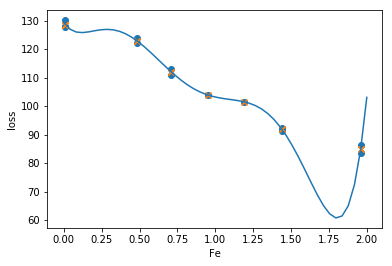

In [30]:
fig, ax = plt.subplots()
ax.scatter(corrosion.Fe, corrosion.loss)
plt.xlabel("Fe")
plt.ylabel("loss")
ax.scatter(corrosion.Fe, amod.fittedvalues, marker='x')
grid = np.linspace(0,2,50)
ax.plot(grid,np.poly1d(pc)(grid))
plt.show()

Manually calculate R-squared.

In [31]:
pc, rss, _, _, _ = np.polyfit(corrosion.Fe, corrosion.loss, 6, full=True)
tss = np.sum((corrosion.loss-np.mean(corrosion.loss))**2)
1-rss/tss

array([0.99653135])

## Robust Regression

Load Galapagos data

In [32]:
gala = pd.read_csv("data/gala.csv",index_col=0)
gala.drop('Endemics', axis=1, inplace=True)
gala.head()

,Species,Area,Elevation,Nearest,Scruz,Adjacent
Baltra,58,25.09,346,0.6,0.6,1.84
Bartolome,31,1.24,109,0.6,26.3,572.33
Caldwell,3,0.21,114,2.8,58.7,0.78
Champion,25,0.10,46,1.9,47.4,0.18
Coamano,2,0.05,77,1.9,1.9,903.82


Least squares fit:

In [33]:
lsmod = smf.ols(formula='Species ~ Area + Elevation + Nearest + Scruz  + Adjacent', data=gala).fit()
lsmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Species   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     15.70
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           6.84e-07
Time:                        15:55:21   Log-Likelihood:                -162.54
No. Observations:                  30   AIC:                             337.1
Df Residuals:                      24   BIC:                             345.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0682     19.154      0.369      0.715     -32.464      46.601
Area          -0.0239      0.022     -1.068      0.296      -0.070       0.022
Elevation      0.3195      0.054      5.953      0.000       0.209       0.430
Nearest        0.0091      1.054      0.009      0.993      -2.166       2.185
Scruz         -0.2405      0.215     -1.117      0.275      -0.685       0.204
Adjacent      -0.0748      0.018     -4.226      0.000      -0.111      -0.038
==============================================================================
Omnibus:                       12.683   Durbin-Watson:                   2.476
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.498
Skew:                           1.136   Prob(JB):                      0.00117
Kurtosis:                       5.374   Cond. No.                     1.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Fit the robust regression using default which is Huber T:

In [34]:
exog = gala.drop('Species',axis=1)
exog = sm.add_constant(exog)
rlmod = sm.RLM(gala.Species,exog).fit()
rlmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                Species   No. Observations:                   30
Model:                            RLM   Df Residuals:                       24
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 25 Sep 2018                                         
Time:                        15:55:21                                         
No. Iterations:                    20                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3626     12.366      0.515      0.607     -17.875      30.600
Area          -0.0061      0.014     -0.422      0.673      -0.034       0.022
Elevation      0.2476      0.035      7.146      0.000       0.180       0.315
Nearest        0.3590      0.681      0.528      0.598      -0.975       1.693
Scruz         -0.1952      0.139     -1.404      0.160      -0.468       0.077
Adjacent      -0.0546      0.011     -4.774      0.000      -0.077      -0.032
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

Check the small weights:

In [35]:
wts = rlmod.weights
wts[wts < 1]

Espanola        0.679642
Gardner1        0.661450
Gardner2        0.850097
Pinta           0.537700
SanCristobal    0.414224
SantaCruz       0.174601
SantaMaria      0.307863
dtype: float64

L1 or LAD fit:

In [36]:
l1mod = sm.QuantReg(gala.Species, exog).fit()
l1mod.summary()

/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                Species   Pseudo R-squared:               0.5064
Model:                       QuantReg   Bandwidth:                       56.17
Method:                 Least Squares   Sparsity:                        106.7
Date:                Tue, 25 Sep 2018   No. Observations:                   30
Time:                        15:55:21   Df Residuals:                       24
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3145     16.754      0.078      0.938     -33.263      35.892
Area          -0.0031      0.020     -0.156      0.877      -0.044       0.037
Elevation      0.2321      0.047      4.945      0.000       0.135       0.329
Nearest        0.1637      0.922      0.177      0.861      -1.739       2.067
Scruz         -0.1231      0.188     -0.654      0.520      -0.512       0.266
Adjacent      -0.0519      0.015     -3.349      0.003      -0.084      -0.020
==============================================================================

The condition number is large, 1.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is not the same as least trimmed squares but as close as we can come with `sm.RLM`:

In [37]:
ltsmod = sm.RLM(gala.Species, exog, M=sm.robust.norms.TrimmedMean()).fit()
ltsmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                Species   No. Observations:                   30
Model:                            RLM   Df Residuals:                       24
Method:                          IRLS   Df Model:                            5
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 25 Sep 2018                                         
Time:                        15:55:21                                         
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5164      7.657      0.329      0.742     -12.490      17.523
Area           0.0023      0.009      0.253      0.800      -0.015       0.020
Elevation      0.2172      0.021     10.124      0.000       0.175       0.259
Nearest        0.6670      0.421      1.583      0.113      -0.159       1.493
Scruz         -0.2229      0.086     -2.589      0.010      -0.392      -0.054
Adjacent      -0.0443      0.007     -6.261      0.000      -0.058      -0.030
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

Results come with standard errors so no need to do bootstrapping.

Fit the Galapagos model without Isabela:

In [38]:
wts = gala.index != 'Isabela'
limod = smf.wls(formula='Species ~ Area + Elevation + Nearest + Scruz  + Adjacent', data=gala, weights=wts).fit()
limod.summary()

/anaconda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:719: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                Species   R-squared:                       0.871
Model:                            WLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     32.53
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           6.14e-10
Time:                        15:55:21   Log-Likelihood:                   -inf
No. Observations:                  30   AIC:                               inf
Df Residuals:                      24   BIC:                               inf
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.5861     13.120      1.722      0.098      -4.492      49.664
Area           0.2957      0.061      4.884      0.000       0.171       0.421
Elevation      0.1404      0.049      2.885      0.008       0.040       0.241
Nearest       -0.2552      0.706     -0.361      0.721      -1.713       1.203
Scruz         -0.0901      0.147     -0.614      0.545      -0.393       0.213
Adjacent      -0.0650      0.012     -5.433      0.000      -0.090      -0.040
==============================================================================
Omnibus:                       13.716   Durbin-Watson:                   2.459
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.482
Skew:                           1.081   Prob(JB):                     0.000160
Kurtosis:                       6.052   Cond. No.                     1.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Show example with multiple outliers:

In [39]:
star = pd.read_csv("data/star.csv")
star.head()

,temp,light
0,4.37,5.23
1,4.56,5.74
2,4.26,4.93
3,4.56,5.74
4,4.30,5.19


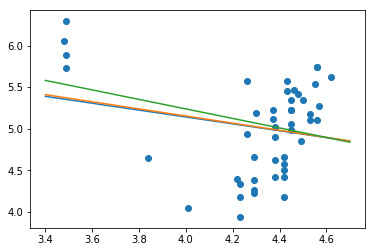

In [40]:
gs1 = smf.ols(formula='light ~ temp', data=star).fit()
gs2 = smf.RLM(star.light, sm.add_constant(star.temp), data=star).fit()
gs3 = smf.RLM(star.light, sm.add_constant(star.temp), data=star,M=sm.robust.norms.TrimmedMean(c=0.1) ).fit()
plt.scatter(star.temp, star.light)
plt.plot([3.4, 4.7], [gs1.params[0] + gs1.params[1]*3.4, gs1.params[0] + gs1.params[1]*4.7])
plt.plot([3.4, 4.7], [gs2.params[0] + gs2.params[1]*3.4, gs2.params[0] + gs2.params[1]*4.7])
plt.plot([3.4, 4.7], [gs3.params[0] + gs3.params[1]*3.4, gs3.params[0] + gs3.params[1]*4.7])
plt.show()

Does not work. This class of estimators cannot do the job for this problem.

In [41]:
%load_ext version_information
%version_information pandas, numpy, matplotlib, seaborn, scipy, patsy, statsmodels

Software,Version
Python,3.7.0 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,6.5.0
OS,Darwin 17.7.0 x86_64 i386 64bit
pandas,0.23.4
numpy,1.15.1
matplotlib,2.2.3
seaborn,0.9.0
scipy,1.1.0
patsy,0.5.0
statsmodels,0.9.0
